In [56]:
# IMPORT ALL LIBRARIES
import numpy as np
import matplotlib.pyplot as plt

import codecs
import re
import os.path

from sklearn.model_selection import train_test_split

# Données reconnaissance du locuteur (Chirac/Mitterrand)

Ceci est un notebook qui va réaliser la tâche de classification de documents appliquée au dataset des présidents Jacques Chirac et François Mitterand.

### Aperçu du dataset:
Cette base est composée de 54413 expressions et phrases tirés de différents discours des anciens présidents français Chirac et Mitterand, chaque expression (document) est étiquetée par un label C ou M (pour Chirac ou Mitterand) et qui indique le président ayant dit cette expression.

L'objectif de ce projet est d'apprendre un classifieur binaire qui permet de prédire pour une expression donnée (Nouvelle expressions provenant de l'un des deux présidents), si elle a été prononcée par le président Chirac ou Mitterand. Le modèle proposé sera ensuite entrainé sur un nouveau test set auquel on n'a pas accès durant la phase d'apprentissage.

## Etape 1: charger les données

In [2]:
# Chargement des données:
def load_pres(fname):
    alltxts = []
    alllabs = []
    s=codecs.open(fname, 'r','utf-8') # pour régler le codage
    while True:
        txt = s.readline()
        if(len(txt))<5:
            break
        # 
        lab = re.sub(r"<[0-9]*:[0-9]*:(.)>.*","\\1",txt)
        txt = re.sub(r"<[0-9]*:[0-9]*:.>(.*)","\\1",txt)
        if lab.count('M') >0:
            alllabs.append(-1)
        else: 
            alllabs.append(1)
        alltxts.append(txt)
    return alltxts,alllabs

In [3]:
fname = "./datasets/corpus.tache1.learn.utf8.txt"
alltxts,alllabs = load_pres(fname)

X = np.array(alltxts)
Y = np.array(alllabs)

X_train, X_test, Y_train, Y_test = train_test_split(alltxts, alllabs, test_size=0.2, shuffle=False)
train_size = len(X_train)
test_size = len(X_test)
print('Train set length : ',train_size)
print('Test set length  : ',test_size)

Train set length :  6990
Test set length  :  1748


In [4]:
print(len(alltxts),len(alllabs))
print(alltxts[0])
print(alllabs[0])
print(alltxts[-1])
print(alllabs[-1])

8738 8738
 Quand je dis chers amis, il ne s'agit pas là d'une formule diplomatique, mais de l'expression de ce que je ressens.

1
 On est venu ici, non pas pour donner le moindre conseil superflu mais on a évoqué en terminant deux problèmes sur lesquels je voudrais mettre l'
1


Remarques:
- Pour les étiquettes y : 
    - L'étiquette -1 représente la classe Chirac
    - L'étiquette -1 représente la classe Mitterand

## Etape 02 : Prétraitement du texte

In [5]:
# Fonctions de prétraitements du texte

from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords as stopwords

import unicodedata
import string
import re

punc = string.punctuation  # recupération de la ponctuation
punc += '\n\r\t'

def lower(corpus, markers = None):
    """ Met le texte en minuscules sauf les mots correspondant aux marqueurs."""
    return [ " ".join( word.upper() if word in markers else word.lower() for word in txt.split() ) for txt in corpus ]

def normalize(corpus):
    """ Suppression des accents et des caractères non normalisés """
    return [ unicodedata.normalize('NFD', txt).encode('ascii', 'ignore').decode("utf-8") for txt in corpus ]

def del_punc(corpus):
    """ Enlève les ponctuations."""
    return [ txt.translate(str.maketrans(punc, ' ' * len(punc))) for txt in corpus ]

def del_num(corpus):
    """ Enlève les chiffres."""
    return [ re.sub('[0-9]+', '', txt) for txt in corpus ] # remplacer une séquence de chiffres par rien

def mark_mulpunc(corpus, marker='MULPUNC'):
    """ Transformation des séquences de ponctuation en un marqueur spécifique (marker) """
    ponctuation = '[' + string.punctuation + ']{2,}'
    return [ re.sub(ponctuation, ' ' + marker + ' ', txt) for txt in corpus ]

def mark_mulmaj(corpus, marker='MULMAJ', n=5):
    """ On ne supprime pas les séquences complètement en majuscule, mais on les fait suivre d'un marqueur (marker)
        @return : str, txt transformé
    """
    marked_corpus = []
    
    for txt in corpus:
        all_maj = re.findall('[A-Z]+[A-Z0-9]{1,}', txt)
        for maj in all_maj:
            #txt = re.sub(maj, maj + ' ' + 'MULMAJ ', txt)
            txt = re.sub(maj,(maj + ' ') * n  + maj, txt)
        marked_corpus.append(txt)
    
    return marked_corpus

def stem(corpus, language):
    """ Racinisation des textes du corpus.
    """
    # Stemmer dans la langue choisie
    stemmer = SnowballStemmer(language, ignore_stopwords=True)
    return [ ' '.join([ stemmer.stem(word) for word in txt.split() ]) for txt in corpus ]

def del_stopwords(corpus, language):
    """ Elimination des stopwords.
    """
    # Liste des stopwords à supprimer (dans la langue choisie)
    stopwords_ = set(stopwords.words(language))
    return [ ' '.join([ word for word in txt.split() if word not in stopwords_ ]) for txt in corpus ]

def select_line(corpus, line=None):
    """ Fonction sélectionnant pour chaque texte du corpus:
            * l'intégralité du texte si line = None
            * la première ligne du texte si line = 0
            * la dernière ligne du texte si line = -1
        A noter que dans les données IMDb, chaque revue a pour dernière ligne ''.
    """
    if line != None:
        return [ txt.split('\n')[:-1][line] for txt in corpus ]
    return corpus

In [6]:
# Nombre moyen de mots par discours
cpt = []
for r in X_train:
    cpt.append(len(r.split()))
np.mean(cpt)

21.543204577968528

### Chaîne de traitements pour le pré-processing de texte:

- sélectionner des lignes
- marquer les ponctuations multiples
- marquer les majuscules multiples
- suppression de la ponctuation
- suppression des chiffres
- mettre en minuscule
- normaliser
- supprimer les stopwords
- stemming

In [40]:
import copy
import string

def text_processor(corpus, language, line=None, mark_punc=False, mark_maj=False, no_punc=False, no_num=False, lowercase=False, norm=False, no_stopwords=False, stemming=False):
    """ Processing paramétrique d'un corpus de texte (cf. chaîne de traitements ci-dessus).
        @param corpus: list(str), corpus de textes
        @param language: {'english', 'french'}
        @param line: {None, 0, -1}, paramètre line de la fonction select_line
        @param mark_mulpunc: {0,1}, vaut 1 si on applique la fonction mark_mulpunc
        @param mark_mulmaj: {0,1}, vaut 1 si on applique la fonction mark_mulmaj
        @param del_punc: {0,1}, vaut 1 si on applique la fonction del_punc
        @param del_num: {0,1}, vaut 1 si on applique la fonction del_num
        @param lower: {0,1}, vaut 1 si on applique la fonction lower
        @param normalize: {0,1}, vaut 1 si on applique la fonction normalize
        @param del_stopwords: {0,1}, vaut 1 si on applique la fonction del_stopwords
        @param stem: {0,1}, vaut 1 si on applique la fonction stem
        @return processed_corpus: list(str), corpus traité
    """
    # Récupération de la ponctuation
    punc = string.punctuation
    punc += '\n\r\t'
    
    # Multiplication multiple
    mulpunc = '[' + string.punctuation + ']{2,}'
    
    # Initialisation du stemmer
    stemmer = SnowballStemmer(language, ignore_stopwords=True)
    
    # Liste des stopwords à supprimer (dans la langue choisie)
    stopwords_ = set(stopwords.words(language))
    
    # Sélection de lignes si spécifié
    processed_corpus = select_line(copy.deepcopy(corpus), line=line)
    
    for i in range(len(processed_corpus)):
        text = processed_corpus[i]
        if mark_punc:
            text = re.sub(mulpunc, ' ' + 'MULPUNC' + ' ', text)
        if mark_maj:
            all_maj = re.findall('[A-Z]+[A-Z0-9]{1,}', text)
            for maj in all_maj:
                text = re.sub(maj, maj + ' ' + 'MULMAJ ', text)
        if no_punc:
            text = text.translate(str.maketrans(punc, ' ' * len(punc)))
        if no_num:
            text = re.sub('[0-9]+', '', text)
        if lowercase:
            markers = ['MULPUNC','MULMAJ']
            text = " ".join( word.upper() if word in markers else word.lower() for word in text.split() )
        if no_stopwords:
            text = ' '.join( word for word in text.split() if word not in stopwords_ )
        if norm:
            text = unicodedata.normalize('NFD', text).encode('ascii', 'ignore').decode("utf-8")
        if stemming:
            text = ' '.join( stemmer.stem(word) for word in text.split() )
        processed_corpus[i] = text
    
    return processed_corpus

In [8]:
import time
import string

start = time.time()
corpus = text_processor(X_train, language='french', line=None, mark_punc=True, mark_maj=True, no_punc=True, no_num=True, lowercase=True, no_stopwords=True, norm=True, stemming=True)
print('Time elapsed: ', time.time() - start)

Time elapsed:  2.200979709625244


## Extraction du vocabulaire
### Exploration préliminaire des jeux de données.

- Quelle est la taille d'origine du vocabulaire?
- Que reste-t-il si on ne garde que les 100 mots les plus fréquents? [word cloud]
- Quels sont les 100 mots dont la fréquence documentaire est la plus grande? [word cloud]
- Quels sont les 100 mots les plus discriminants au sens de odds ratio? [word cloud]
- Quelle est la distribution d'apparition des mots (Zipf)
- Quels sont les 100 bigrammes/trigrammes les plus fréquents?

### Exploration préliminaire des données présidentielles:

1. Taille d'origine du vocabulaire:

In [9]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

vectorizer = TfidfVectorizer(min_df=10)
X = vectorizer.fit_transform(X_train)

# Affichage
vocabulaire = vectorizer.get_feature_names_out()
print('Taille du vocabulaire = ', len(vocabulaire))
print(X.toarray())

Taille du vocabulaire =  1664
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


2. Que reste-t-il si on ne garde que les 100 mots les plus fréquents? [word cloud]

In [10]:
from collections import Counter

xarray = X.toarray()
occurrences = np.sum(xarray, axis=0)
counter = Counter( { vocabulaire[i] : occurrences[i] for i in range(len(vocabulaire)) } )
counter.most_common(100)

[('de', 576.7323180347579),
 ('la', 443.87686701831507),
 ('et', 380.2817320137796),
 ('le', 333.1470256460921),
 ('les', 323.8579220828825),
 ('est', 283.24662421578563),
 ('des', 281.8872230316118),
 ('en', 243.17715602323995),
 ('que', 231.67788961649924),
 ('qui', 214.6193999772385),
 ('nous', 210.63856870731428),
 ('un', 203.29928542556758),
 ('une', 199.364266643952),
 ('pour', 193.11026753856146),
 ('vous', 183.02743901027415),
 ('dans', 182.0360227867075),
 ('je', 178.42330574076072),
 ('il', 177.35756045951962),
 ('du', 174.2565417356851),
 ('ce', 149.55641997995846),
 ('plus', 143.73128055358433),
 ('au', 142.86763414319014),
 ('pas', 139.283962281556),
 ('nos', 125.76144804443888),
 ('notre', 124.5378810878636),
 ('france', 120.66806288459014),
 ('ne', 110.57715671885708),
 ('par', 109.36319318963534),
 ('sur', 108.70144080796977),
 ('qu', 108.61565587338279),
 ('avec', 104.3074901859171),
 ('elle', 104.29364938945118),
 ('cette', 103.67121318973851),
 ('mais', 99.3038980352

3. Quels sont les 100 mots dont la fréquence documentaire est la plus grande? [word cloud]

5588 lignes Chirac


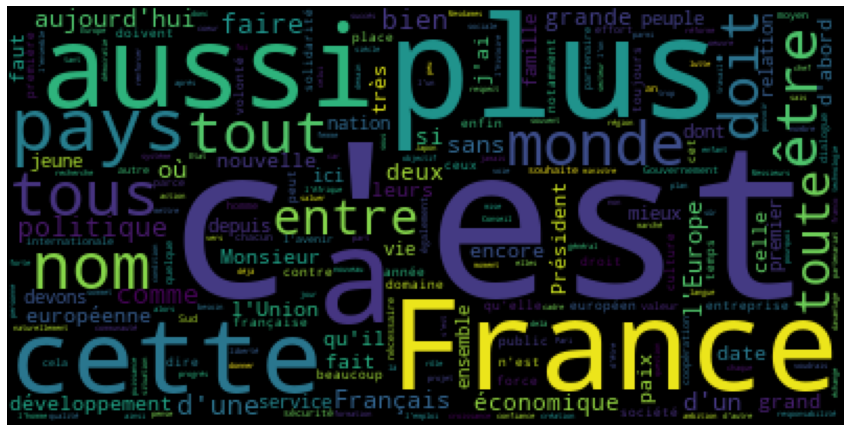

In [11]:
# Wordcloud sur les discours de Chirac

from wordcloud import WordCloud
from PIL import Image

x_chirac = [ X_train[i] for i in range(len(X_train)) if Y_train[i] == 1 ]
print('{} lignes Chirac' .format(len(x_chirac)))

text = ' '.join( [ d for d in x_chirac ] )
stopwords_ = set(stopwords.words('french'))

wc = WordCloud(background_color="black", max_words=500,
               collocations=False, stopwords=stopwords_, contour_width=3, contour_color='lightsteelblue')
wc.generate(text)

# Affichage
plt.figure(figsize = (15,10))
plt.imshow(wc)
plt.axis("off")
plt.show()

1402 lignes Mitterand


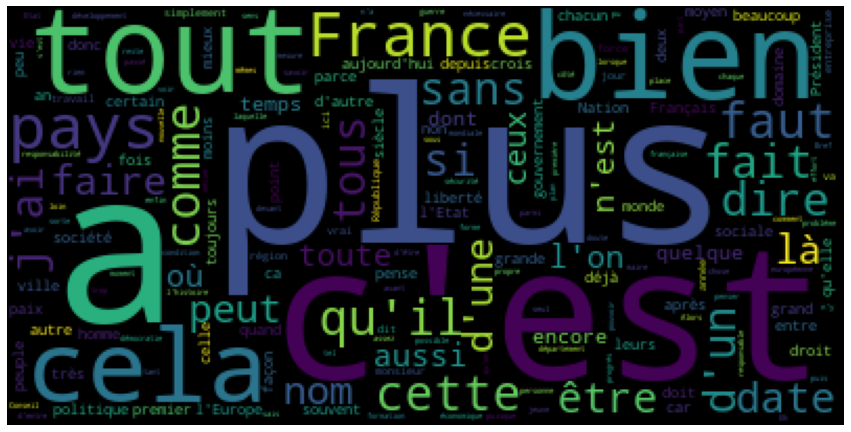

In [12]:
# Wordcloud sur les discours du président Mitterand

from wordcloud import WordCloud
from PIL import Image

x_mitterand = [ X_train[i] for i in range(len(X_train)) if Y_train[i] == -1 ]
print('{} lignes Mitterand' .format(len(x_mitterand)))

text = ' '.join( [ d for d in x_mitterand ] )
stopwords_ = set(stopwords.words('french'))

wc = WordCloud(background_color="black", max_words=500,
               collocations=False, stopwords=stopwords_, contour_width=3, contour_color='lightsteelblue')
wc.generate(text)

# Affichage
plt.figure(figsize = (15,10))
plt.imshow(wc)
plt.axis("off")
plt.show()

4. Quels sont les 100 mots les plus discriminants au sens de odds ratio? [word cloud]

In [19]:
class Odds_Ratio:
    """ Classe pour calculer les odds ratio 
    """
    def __init__(self, datax, datay, labels):
        """ Constructeur de la classe Odds_Ratio.
            @param datax: list(str), corpus de textes
            @param datay: list(str), classes corrspondantes
            @param labels: list(int), liste des classes distinctes
        """
        self.datax = datax
        self.datay = datay
        self.labels = labels
        
        # Calcul des odds ratios
        self.compute()
        
    def compute(self):
        """ Calcule les odds ratios pour un problème à 2 classes (classe -1 par rapport à classe 1).
        """
        # Sous-corpus de classe label
        self.datax_1 = [ self.datax[i] for i in range(len(self.datax)) if self.datay[i] == self.labels[0] ]
        self.datax_2 = [ self.datax[i] for i in range(len(self.datax)) if self.datay[i] == self.labels[1] ]

        # Récupération du vocabulaire pour la 1ère classe 1
        vectorizer_1 = CountVectorizer()
        X_1 = vectorizer_1.fit_transform(self.datax_1)
        vocab_1 = vectorizer_1.get_feature_names_out()
        occ_1 = np.sum(X_1.toarray(), axis=0)

        # Récupération du vocabulaire pour la 2ème classe
        vectorizer_2 = CountVectorizer()
        X_2 = vectorizer_2.fit_transform(self.datax_2)
        vocab_2 = vectorizer_2.get_feature_names_out()
        occ_2 = np.sum(X_2.toarray(), axis=0) 

        # Vocabulaire global
        vocab = set(vocab_1).union(vocab_2)

        # Calcul des tf de la 1ère classe
        tf_1 = { vocab_1[i] : occ_1[i] for i in range(len(vocab_1)) }
        total_1 = sum(tf_1.values())
        p = { word: tf_1.get(word, 0) / total_1 for word in vocab }

        # Calcul des tf de la 2e classe
        tf_2 = { vocab_2[i] : occ_2[i] for i in range(len(vocab_2)) }
        total_2 = sum(tf_2.values())
        q = { word: tf_2.get(word, 0) / total_2 for word in vocab }

        # Calcul des odds ratio
        self.odds_ratio = { word : ( p[word] * (1 - q[word]) + 0.1 ) / ( q[word] * (1 - p[word]) + 0.1 ) for word in vocab }
    
    def wordcloud(self, label, n, language='english', mask=None):
        """ Affichage du wordcloud de n mots associé au label entré en paramètre. 
            @param label: int, classe dont on veut afficher le wordcloud
            @param n: int, nombre de mots à prendre en compte dans le wordcloud
        """        
        reverse = True if label == self.labels[0] else False
        sorted_ratios = dict( sorted( self.odds_ratio.items(), key=lambda item: item[1], reverse=reverse))
        ratios_dict = { word : sorted_ratios[word] if reverse==True else 1/sorted_ratios[word]  for word in list(sorted_ratios.keys())[:n] }
        
        stopwords_ = set(stopwords.words(language))

        wc = WordCloud(background_color="black", max_words=n, mask=mask,
                       collocations=False, stopwords=stopwords_, contour_width=3, contour_color='thistle')
        wc.generate_from_frequencies(ratios_dict)

        # Affichage
        plt.figure(figsize = (15,10))
        plt.imshow(wc)
        plt.axis("off")
        plt.show()

In [20]:
# Pré-processing du texte
xtrain = text_processor(X_train, language='french', line=None, mark_punc=True, mark_maj=True, no_punc=True, no_num=True, lowercase=True, no_stopwords=True, norm=True, stemming=True)

Wordcloud pour les discours de Chirac


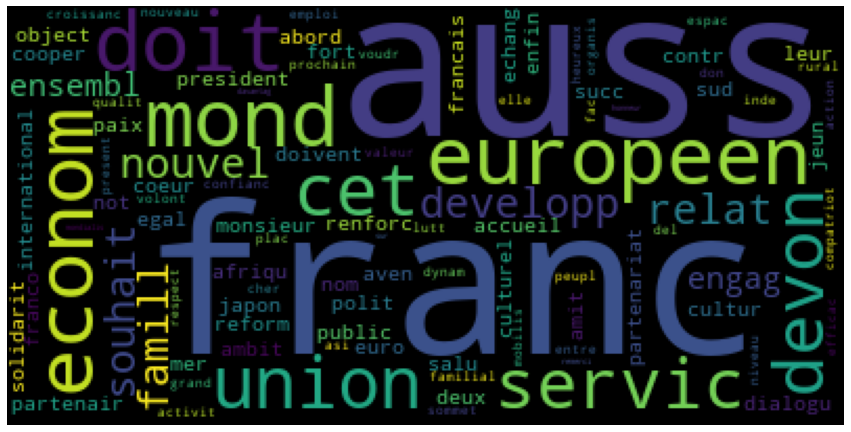

Wordcloud pour les discours de Mittérand


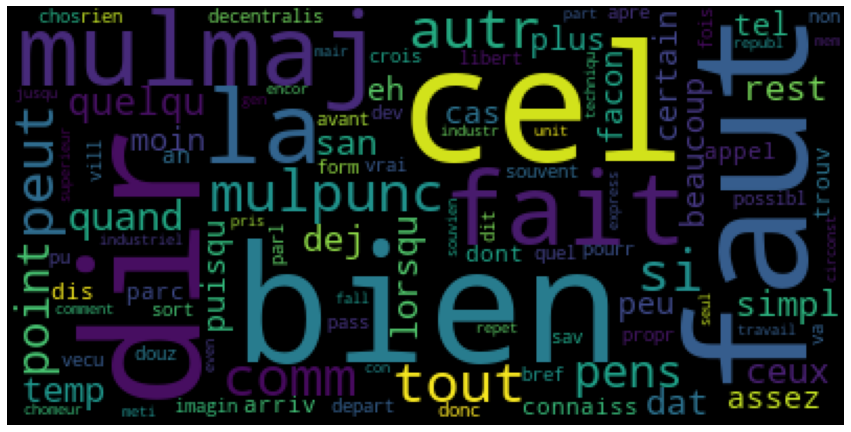

In [21]:
# Odds ratios
odds_ratio = Odds_Ratio(xtrain, Y_train, labels=[1,-1])
print('Wordcloud pour les discours de Chirac')
odds_ratio.wordcloud( label = 1, n = 100, language = 'french')
print('Wordcloud pour les discours de Mittérand')
odds_ratio.wordcloud( label = -1, n = 100, language = 'french')

5. Quelle est la distribution d'apparition des mots (Zipf)
- Quels sont les 100 bigrammes/trigrammes les plus fréquents?

In [31]:
from sklearn.feature_extraction.text import CountVectorizer

# initialize CountVectorizer object
vectorizer = CountVectorizer()

# fit and transform the corpus into a document-term matrix
dtm = vectorizer.fit_transform(corpus)

# get the vocabulary (unique words in the corpus) and their counts
vocab = vectorizer.vocabulary_
word_counts = dtm.sum(axis=0)

# create a list of (word, count) tuples, sorted by count in descending order
word_freq = [(word, word_counts[0, idx]) for word, idx in vocab.items()]
word_freq = sorted(word_freq, key=lambda x: x[1], reverse=True)

# print the 10 most frequent words
print(word_freq[:10])

[('franc', 985), ('plus', 921), ('tout', 756), ('cet', 706), ('mulmaj', 679), ('pay', 562), ('auss', 554), ('grand', 462), ('etre', 457), ('cel', 409)]


(-0.5, 399.5, 199.5, -0.5)

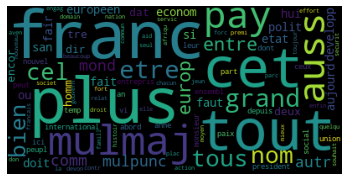

In [33]:
# Your code here
wordcloud = WordCloud(background_color='black', stopwords = stopwords_, max_words=100)
wordcloud.generate_from_frequencies(frequencies=dict(word_freq))

plt.figure()
plt.imshow(wordcloud)
plt.axis("off")

# Modèles de Machine Learning

In [47]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from collections import Counter

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, cross_validate

import time

In [49]:
# Pré-processing du texte
xtrain = text_processor(X_train, language='french', line=None, mark_punc=True, mark_maj=True, no_punc=True, no_num=True, lowercase=True, no_stopwords=True, norm=True, stemming=True)

In [50]:
# Représentation vectorielle des données présidentielles

vectorizer_pres = CountVectorizer()
xtrain = vectorizer_pres.fit_transform(xtrain)
vocabulaire_pres = vectorizer_pres.get_feature_names_out()

In [51]:
############################################## SANS VALIDATION CROISEE  ################################################

# Création modèle, phase d'apprentissage
clf = LinearSVC()
clf.fit(xtrain, Y_train)

# Prédictions sur quelques données
yhat = clf.predict(xtrain[-10:])
y = Y_train[-10:]

print('Prédictions:', yhat)
print('Vraies classes', y)

print('Score sur les données d\'entraînement:', clf.score(xtrain, Y_train) )
print('Vecteur de poids du SVM:', clf.coef_)

Prédictions: [1 1 1 1 1 1 1 1 1 1]
Vraies classes [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Score sur les données d'entraînement: 0.9861230329041488
Vecteur de poids du SVM: [[-0.28447212  0.3047886  -0.3388344  ... -0.26489977  0.
   0.55141844]]


In [52]:
##################################### EN VALIDATION CROISEE, KFOLD, SHUFFLE = FALSE #######################################

from sklearn.model_selection import KFold, cross_val_score

# Création modèle, phase d'apprentissage
clf = LinearSVC()

# Prédictions sur quelques données
kfold = KFold(n_splits=5, shuffle=False)
scores_cv = cross_val_score(clf, xtrain, Y_train, cv=kfold)

print('Score sur les données d\'entraînement:', scores_cv )

Score sur les données d'entraînement: [0.78397711 0.77610873 0.78183119 0.81258941 0.8111588 ]


In [53]:
##################################### EN VALIDATION CROISEE, KFOLD, SHUFFLE = TRUE #######################################

from sklearn.model_selection import KFold, cross_val_score

# Création modèle, phase d'apprentissage
clf = LinearSVC()

# Prédictions sur quelques données
kfold = KFold(n_splits=5, shuffle=True)
scores_cv = cross_val_score(clf, xtrain, Y_train, cv=kfold)

print('Score sur les données d\'entraînement:', scores_cv )

Score sur les données d'entraînement: [0.81187411 0.81330472 0.81258941 0.81688126 0.8018598 ]


In [54]:
################################ EN VALIDATION CROISEE, STRATIFIEDKFOLD, SHUFFLE = FALSE ##################################

from sklearn.model_selection import StratifiedKFold, cross_val_score

# Par défaut cross_val_score utilise déjà StratifiedKFold, mais on veut mettre le paramètre shuffle à False

# Création modèle, phase d'apprentissage
clf = LinearSVC()

# Prédictions sur quelques données
strat_kfold = StratifiedKFold(n_splits=5, shuffle=False)
scores_cv = cross_val_score(clf, xtrain, Y_train, cv=strat_kfold)

print('Score sur les données d\'entraînement:', scores_cv )

Score sur les données d'entraînement: [0.79899857 0.78755365 0.78826896 0.80686695 0.78397711]


In [55]:
################################ EN VALIDATION CROISEE, STRATIFIEDKFOLD, SHUFFLE = TRUE ##################################

# Par défaut cross_val_score utilise déjà StratifiedKFold, mais on veut mettre le paramètre shuffle à True

# Création modèle, phase d'apprentissage
clf = LinearSVC()

# Prédictions sur quelques données
strat_kfold = StratifiedKFold(n_splits=5, shuffle=True)
scores_cv = cross_val_score(clf, xtrain, Y_train, cv=strat_kfold)

print('Score sur les données d\'entraînement:', scores_cv )


Score sur les données d'entraînement: [0.81688126 0.82260372 0.81473534 0.81616595 0.80686695]


# Document classification :

## A. Processing chain design
**Main steps:**
1. Data reading \& importation
    - The corpus can be loaded in RAM (otherwise, you should use a *data loader* to bufferise the importation)
    - Encoding is a big problem: you have to make sure that the data are correctly read.
2. Data pre-processing, transformation \& filtering
    - remove *useless* information: figures, ponctuations, capitals, *etc*... **usefulness depends on applications! [obviously]**
    - Segment into words (=*Tokenization*)
    - Elimination of stop-words
    - Stemming/lemmatization (rootization)
    - Byte-pair encoding to find compound words (e.g. Sorbonne University, City of Paris, Prime Minister, etc...)
3. Digital data processing (Bag-of-Words)
    - Normalization *term-frequency* / binarization
    - Inverse document frequency* normalization
    - Elimination of rare words, too frequent words
    - Construction of separability criteria to eliminate words etc...
4. Learning a classifierµ
    - Choice of the type of classifier
    - Adjustment of the parameters of the classifier (regularization, balancing, etc...)

## B. Exploitation of the processing chain

This step is called the realization of a campaign of experiments: it is the key point that we want to work on in NLP this year.
1. It is impossible to test all the combinations in relation to the above proposals... Therefore, we have to eliminate some of them.
    - By discussing with the business experts
    - By doing preliminary tests
1. After this first filtering, we must:
    - Choose an evaluation that is reliable and not too slow (cross-validation, leave-one-out, split learning/single test)
    - Run large experiments
        - = *grid-search
        - parallelise on several machines
        - know how to run on a server and disconnect
1. Collect and analyze results


## C. Inference & industrialization

The inference is then very classical: the optimal processing chain is able to process new documents

# A) Transformation paramétrique du texte (pre-traitements)

Vous devez tester, par exemple, les cas suivants:
- transformation en minuscule ou pas
- suppression de la ponctuation
- transformation des mots entièrement en majuscule en marqueurs spécifiques
- suppression des chiffres ou pas
- conservation d'une partie du texte seulement (seulement la première ligne = titre, seulement la dernière ligne = résumé, ...)
- stemming
- ...


Vérifier systématiquement sur un exemple ou deux le bon fonctionnement des méthodes sur deux documents (au moins un de chaque classe).

In [9]:
import re
import unidecode
import io
import string
import unicodedata

reg = "\b[^\W]\b" #matches word with characters 

# 1) Try removing punctuation or putting text to lower case (maybe use a regex)
# 2) Try "Stemming" - "pos-tagging" the text

def preprocess(text):
    """
    Transforms text to remove unwanted bits.
    """
    # replace url by a keywork URL
    text = re.sub('(www|http)[\w\.-_]+\.(fr|com|org)', 'URL', text)  # note: this regex is far from perfect
    # remove numbers
    text = re.sub('[0-9]+', '', text) # remplacer une séquence de chiffres par rien   
    # remove punctuation
    punc = string.punctuation  
    punc += '\n\r\t'
    text = text.translate(str.maketrans(punc, ' ' * len(punc)))  
    # remove accents
    text = unicodedata.normalize('NFD', text).encode('ascii', 'ignore').decode("utf-8")
    # remove uppercase
    text = text.lower()
    
    return text.replace("."," ") # This function is only taking care of dots, what about !:,?+-&*%

**(b) Dictionary processing**: If we visualize the word frequency distribution we see that a few words (roughly 20) appear a lot more than the others. These words are often refered to as **stop words**. Would remove them improve accuracy ?

In [ ]:
vectorizer = CountVectorizer(preprocessor=preprocess)
X = vectorizer.fit_transform(corpus)

[('de', 10198), ('', 8738), ('la', 6079), ('et', 5293), ('à', 3954), ('le', 3859), ('les', 3619), ('des', 3168), ('que', 2489), ('qui', 2324), ('en', 2188), ('pour', 1733), ('dans', 1670), ('du', 1634), ('un', 1397), ('une', 1340), ('nous', 1219), ('au', 1096), ('plus', 1094), ('vous', 1084)]


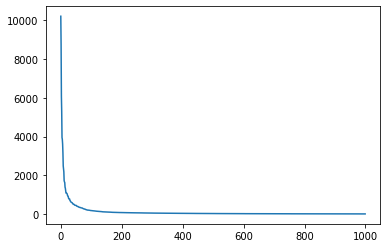

In [18]:
# Let's plot the count of the 1000 most used words:

import matplotlib.pyplot as plt
%matplotlib inline

from collections import Counter

wc = Counter()
for text in corpus:
    wc.update(text.split(" "))
    
freq = [f for w,f in wc.most_common(1000)]

plt.plot(freq[:1000])
print(wc.most_common(20))

**Let's remove stopwords:** english stop words: direclty on sklearn 

- **stop_words:** string {‘english’}, list, or None (default)
    - If ‘english’, a built-in stop word list for English is used. There are several known issues with ‘english’ and you should consider an alternative (see Using stop words).
    - If a list, that list is assumed to contain stop words, all of which will be removed from the resulting tokens. Only applies if analyzer == 'word'.
    - If None, no stop words will be used. max_df can be set to a value in the range [0.7, 1.0) to automatically detect and filter stop words based on intra corpus document frequency of terms.

[see CountVectorizer for full doc](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)

In [19]:
# French stop words: nltk
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
final_stopwords_list = stopwords.words('english') + stopwords.words('french')
#print(final_stopwords_list)
vectorizer = CountVectorizer(stop_words=final_stopwords_list)
#vectorizer = TfidfVectorizer(stop_words=final_stopwords_list)

**Build your own list**

In [12]:
# CountVectorizer can take a list of stop words as argument.
# Build or download a list of stop word (from NLTK for exemple)

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
nltk.download('stopwords')

# remove stop words
stop_words = list(stopwords.words('french'))

vectorizer = CountVectorizer(stop_words=stop_words)
print(X.shape)
X = vectorizer.fit_transform(corpus)
X.shape

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


(8738, 12617)


(8738, 12504)

In [ ]:
# print(len(X_train))
# stemmer = snowballstemmer.stemmer('french');
# for i in range(len(X_train)):
#     stemmer.stemWords(X_train[i].split()[j] for j in range(len(X_train[i].split())))
# print(np.array(X_train).shape)
# for i in range(len(X_test)):
#     stemmer.stemWords(X_test[i].split()[j] for j in range(len(X_test[i].split())))

**(b) Dictionary processing, restricting vocabulary size: corpus-specific stopwords** => max_df + suppress rare words (min_df) + max_features 

- **max_df:** float in range [0.0, 1.0] or int, default=1.0
When building the vocabulary ignore terms that have a document frequency strictly higher than the given threshold (corpus-specific stop words). If float, the parameter represents a proportion of documents, integer absolute counts. This parameter is ignored if vocabulary is not None.

- **min_df:** float in range [0.0, 1.0] or int, default=1
When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold. This value is also called cut-off in the literature. If float, the parameter represents a proportion of documents, integer absolute counts. This parameter is ignored if vocabulary is not None.

- **max_features:** int or None, default=None
If not None, build a vocabulary that only consider the top max_features ordered by term frequency across the corpus.
This parameter is ignored if vocabulary is not None.

[see CountVectorizer for full doc](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)

In [22]:
# max_df: float (ratio) / integer(number) of document above which we remove the word)
# min_df: float (ratio) / integer(number) of document under which we remove the word)

min_df=5
max_df=0.5
max_features=10000
vectorizer = CountVectorizer(max_df=max_df,min_df=min_df,max_features=max_features)  #try out some values
X = vectorizer.fit_transform(corpus)
#What is the dictionnary size now ?
dic_size = X.shape[1]###
print(dic_size)

3484


**(c) : Binary BoW**: instead of word counts, the bag of word vector can only represent used word.

- **binary:** boolean, default=False
If True, all non zero counts are set to 1. This is useful for discrete probabilistic models that model binary events rather than integer counts.

[see CountVectorizer for full doc](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)

In [20]:
min_df=5
max_df=0.5
max_features=10000
vectorizer = CountVectorizer(binary=True)
X = vectorizer.fit_transform(corpus)
dic_size = X.shape[1]###
print(X.shape)

print(type(X))

(8738, 12617)
<class 'scipy.sparse.csr.csr_matrix'>


In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

use_idf=True,          
smooth_idf=True
sublinear_tf=False

vectorizer = TfidfVectorizer(use_idf= use_idf, smooth_idf=smooth_idf, sublinear_tf=sublinear_tf)
X = vectorizer.fit_transform(corpus)
print(X.shape)

(8738, 12617)


**(e) n-grams**: instead of words, consider n-uplets of words as tokens

- **ngram_range:** tuple (min_n, max_n)
The lower and upper boundary of the range of n-values for different n-grams to be extracted. All values of n such that min_n <= n <= max_n will be used.

- **analyzer:** string, {‘word’, ‘char’, ‘char_wb’} or callable
Whether the feature should be made of word or character n-grams. Option ‘char_wb’ creates character n-grams only from text inside word boundaries; n-grams at the edges of words are padded with space.
If a callable is passed it is used to extract the sequence of features out of the raw, unprocessed input.

[see CountVectorizer for full doc](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)

In [22]:
ngram_range = (1,2) # unigrams and bigrams
vectorizer = CountVectorizer(ngram_range=ngram_range,analyzer='word') # Maybe 2-grams or 3-grams bring improvements ?
X = vectorizer.fit_transform(corpus)
#What is the dictionnary size now ?
dic_size = X.shape[1]###
print(dic_size)

91946


# B) Extraction du vocabulaire (BoW)

- **Exploration préliminaire des jeux de données**
    - Quelle est la taille d'origine du vocabulaire?
    - Que reste-t-il si on ne garde que les 100 mots les plus fréquents? [word cloud]
    - Quels sont les 100 mots dont la fréquence documentaire est la plus grande? [word cloud]
    - Quels sont les 100 mots les plus discriminants au sens de odds ratio? [word cloud]
    - Quelle est la distribution d'apparition des mots (Zipf)
    - Quels sont les 100 bigrammes/trigrammes les plus fréquents?

- **Variantes de BoW**
    - TF-IDF
    - Réduire la taille du vocabulaire (min_df, max_df, max_features)
    - BoW binaire
    - Bi-grams, tri-grams
    - **Quelles performances attendrent? Quels sont les avantages et les inconvénients des ces variantes?**

In [24]:
# On se limite au premier modèle de représentation bow
vectorizer = CountVectorizer(preprocessor=preprocess)
X = vectorizer.fit_transform(corpus)

In [26]:
# La taille d'origine du vocabulaire
print('Taille du vocabulaire :', X.shape[1])

Taille du vocabulaire : 12098


(-0.5, 399.5, 199.5, -0.5)

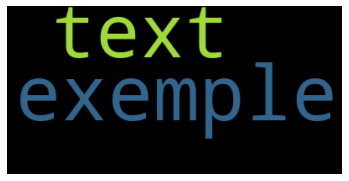

In [27]:
# Que se passe t'il si on ne garde que les 100 mots les plus fréquents
from wordcloud import WordCloud

# Get text:
text = "this is exemple text"

# Generate a word cloud image
wordcloud = WordCloud().generate(text)

# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")


# C) Modèles de Machine Learning

## 1) Métriques d'évaluation 

Il faudra utiliser des métriques d'évaluation pertinentes suivant la tâche et l'équilibrage des données : 
- Accuracy
- Courbe ROC, AUC, F1-score

## 2) Variantes sur les stratégies d'entraînement

- **Sur-apprentissage**. Les techniques sur lesquelles nous travaillons étant sujettes au sur-apprentissage: trouver le paramètre de régularisation dans la documentation et optimiser ce paramètre au sens de la métrique qui vous semble la plus appropriée (cf question précédente).

 <br>
- **Equilibrage des données**. Un problème reconnu comme dur dans la communauté est celui de l'équilibrage des classes (*balance* en anglais). Que faire si les données sont à 80, 90 ou 99% dans une des classes?
Le problème est dur mais fréquent; les solutions sont multiples mais on peut isoler 3 grandes familles de solution.

1. Ré-équilibrer le jeu de données: supprimer des données dans la classe majoritaire et/ou sur-échantilloner la classe minoritaire.<BR>
   $\Rightarrow$ A vous de jouer pour cette technique
1. Changer la formulation de la fonction de coût pour pénaliser plus les erreurs dans la classe minoritaire:
soit une fonction $\Delta$ mesurant les écarts entre $f(x_i)$ et $y_i$ 
$$C = \sum_i  \alpha_i \Delta(f(x_i),y_i), \qquad \alpha_i = \left\{
\begin{array}{ll}
1 & \text{si } y_i \in \text{classe majoritaire}\\
B>1 & \text{si } y_i \in \text{classe minoritaire}\\
\end{array} \right.$$
<BR>
   $\Rightarrow$ Les SVM et d'autres approches sklearn possèdent des arguments pour régler $B$ ou $1/B$... Ces arguments sont utiles mais pas toujours suffisant.
1. Courbe ROC et modification du biais. Une fois la fonction $\hat y = f(x)$ apprise, il est possible de la *bidouiller* a posteriori: si toutes les prédictions $\hat y$ sont dans une classe, on va introduire $b$ dans $\hat y = f(x) + b$ et le faire varier jusqu'à ce qu'un des points change de classe. On peut ensuite aller de plus en plus loin.
Le calcul de l'ensemble des scores associés à cette approche mène directement à la courbe ROC.

**Note:** certains classifieurs sont intrinsèquement plus résistante au problème d'équilibrage, c'est par exemple le cas des techniques de gradient boosting que vous verrez l'an prochain.


## 3) Estimer les performances de généralisation d'une méthodes
**Ce sera l'enjeu principal du projet : vous disposez d'un ensemble de données, et vous évaluerez les performances sur un ensemble de test auquel vous n'avez pas accès. Il faut donc être capable d'estimer les performances de généralisation du modèles à partir des données d'entraînement.**


Avant de lancer de grandes expériences, il faut se construire une base de travail solide en étudiant les questions suivantes:

- Combien de temps ça prend d'apprendre un classifieur NB/SVM/RegLog sur ces données en fonction de la taille du vocabulaire?
- La validation croisée est-elle nécessaire? Est ce qu'on obtient les mêmes résultats avec un simple *split*?
- La validation croisée est-elle stable? A partir de combien de fold (travailler avec différentes graines aléatoires et faire des statistiques basiques)?

Avant de lancer une grande expérimentation, il est en effet important de construire une base de travail solide et de répondre à certaines questions clés pour assurer la qualité de la recherche. Voici quelques éléments de réponse aux questions que vous avez posées :

- Le temps nécessaire pour apprendre un classifieur (NB/SVM/RegLog) dépend de plusieurs facteurs, tels que la taille du corpus, la taille du vocabulaire, la complexité du modèle et les ressources de calcul disponibles. Pour estimer le temps d'apprentissage, il est recommandé de réaliser des expériences préliminaires sur un échantillon du corpus, en faisant varier la taille du vocabulaire, et de mesurer le temps nécessaire pour entraîner le modèle. Cela permettra de déterminer le temps approximatif nécessaire pour entraîner un modèle sur l'ensemble du corpus.

- La validation croisée est généralement recommandée pour évaluer les performances d'un modèle de manière robuste et fiable. Cela permet d'éviter les biais liés à la partition des données et de garantir une évaluation plus objective des performances. Un simple split des données en deux parties (train/test) peut donner des résultats biaisés en fonction de la distribution des classes et des exemples dans chaque partie. La validation croisée permet de réduire ce biais en utilisant plusieurs partitions différentes et en moyennant les performances sur l'ensemble des partitions.

- La stabilité de la validation croisée dépend de plusieurs facteurs, tels que le nombre de partitions (folds), la taille de chaque partition, la distribution des classes et des exemples dans chaque partition, et la variabilité des performances du modèle. Pour évaluer la stabilité de la validation croisée, il est recommandé de réaliser des expériences avec différentes graines aléatoires, en faisant varier le nombre de folds, et de mesurer les performances moyennes et leur variabilité. En général, il est recommandé d'utiliser au moins 5-10 folds pour une estimation fiable des performances, mais ce nombre peut varier en fonction de la taille du corpus et de la complexité du modèle.

 # Post traitement
 A kindof aposteriori on the data using the apriori of : if one locutor speaks